Import Lib

In [291]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic import BaseModel, Field
from typing import TypedDict, Literal
from dotenv import load_dotenv

In [292]:
load_dotenv()

True

In [293]:
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.7
)

#### Make the model Structure

In [294]:
class sentimentSchema(BaseModel):
  sentiment:Literal["Positive", "Negative"] = Field(description="Sentiment of the review")

In [295]:
class diagnosisSchema(BaseModel):
  issue:Literal['UX', 'Performance', 'Bug', 'Support', 'Other'] = Field(description=f"I want the issue that listed in the review")
  tone:Literal['angry', 'frustrated', 'disappointed', 'calm'] = Field(description="The emotional tone expreeesed by the user or customer")
  urgency:Literal['low', 'medium', 'high'] = Field(description="How urgent or critical the issue appears to be")

In [296]:
structureModel = model.with_structured_output(sentimentSchema)
diagnosisModel = model.with_structured_output(diagnosisSchema)

In [297]:
prompt = "What is the sentiment of the following review - The software is bad"
structureModel.invoke(prompt)

sentimentSchema(sentiment='Negative')

#### 1. State

In [298]:
class messageReviewState(TypedDict):
  review:str
  sentiment:Literal["Positive", "Negative"]
  diagnosis:dict
  response:str
  

#### Functions

In [299]:
def findSentiment(state:messageReviewState)->messageReviewState:
  prompt = f"Give me the sentiment of the following review - {state['review']}"
  sentiment = structureModel.invoke(prompt).sentiment

  return {'sentiment': sentiment}

In [300]:
def runDiagnosis(state:messageReviewState)->dict:
  prompt = f"On the basic of the review\n {state['review']}\n the sentiment of the customer is {state['sentiment']} & in return I want a issue type, tone of the customer and the urgency of his work "
  
  response = diagnosisModel.invoke(prompt)
  return {'diagnosis':response.model_dump()}

In [308]:
def positiveReview(state:messageReviewState)->messageReviewState:
  prompt = f"You are a helful assistant\nGenerate the {state['sentiment']},  replied to the customer on the basic on the following review that he gave - {state['review']}\n Also , kindly ask him to give me the review on the website & the response should not be a draft one"

  response =  model.invoke(prompt).content
  return {'response': response}

In [302]:
def negativeReview(state:messageReviewState)->messageReviewState:
  diagnosis = state['diagnosis']
  prompt = f"You are a Support assistant\nReplied to the customer on the basic on the following review that he gave - {state['review']} and the problem that he listed so make the message in such a way that he satisfy. The problem faced by the customer is {diagnosis['issue']} and the tone is {diagnosis['tone']} write an empthatic, helpful resolution message. I don't need any draft things just pure message" 

  response =  model.invoke(prompt).content
  return {'response': response}

#### Conditional Function

In [303]:
def checkSentiments(state:messageReviewState)->Literal["positiveReview", "runDiagnosis"]:
  if state['sentiment'] == "Positive":
    return "positiveReview"
  else:
    return "runDiagnosis"


#### 2. Graph

##### 2.1 Defining the Graph

In [304]:
graph = StateGraph(messageReviewState)

graph.add_node('findSentiment', findSentiment)
graph.add_node('runDiagnosis', runDiagnosis)
graph.add_node('negativeReview', negativeReview)
graph.add_node('positiveReview', positiveReview)

graph.add_edge(START, 'findSentiment')

graph.add_conditional_edges('findSentiment', checkSentiments)
graph.add_edge('runDiagnosis', 'negativeReview')
graph.add_edge('negativeReview', END)
graph.add_edge('positiveReview', END)

workflow = graph.compile()

##### 2.2 Showing the Workflow

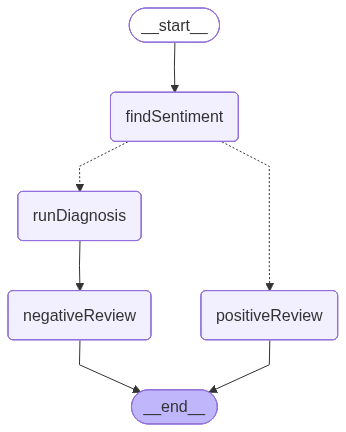

In [305]:
workflow

##### 2.3 Execute the Workflow

Positive Review

In [307]:
initalState = {
  'review':"This software has exceeded my expectations! The user interface is clean and intuitive, making it easy to navigate even for beginners. Performance is smooth, and I haven’t experienced any lags or crashes. I especially appreciate the regular updates and quick bug fixes from the development team. The customer support is responsive and helpful. Overall, it’s a reliable tool that has improved my productivity significantly."
}

workflow.invoke(initalState)

{'review': 'This software has exceeded my expectations! The user interface is clean and intuitive, making it easy to navigate even for beginners. Performance is smooth, and I haven’t experienced any lags or crashes. I especially appreciate the regular updates and quick bug fixes from the development team. The customer support is responsive and helpful. Overall, it’s a reliable tool that has improved my productivity significantly.',
 'sentiment': 'Positive',
 'response': "Okay, here's a positive response to the customer's review, along with a request for them to post it on your website:\n\nSubject: Thank you for your amazing feedback!\n\nDear [Customer Name],\n\nWow! Thank you so much for taking the time to share such a positive and detailed review of our software. We are absolutely thrilled to hear that it has exceeded your expectations and significantly improved your productivity.\n\nWe're especially happy that you find the user interface clean and intuitive, and that you're experienc

Negative Review

In [306]:
initalState = {
  'review':"I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}

workflow.invoke(initalState)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'Negative',
 'diagnosis': {'issue': 'Bug', 'tone': 'angry', 'urgency': 'high'},
 'response': "I understand your frustration, and I sincerely apologize for the trouble you're experiencing with the app. It's completely unacceptable that you've been locked out for over an hour due to this freezing issue, especially after reinstalling.\n\nWe're aware of a bug affecting some users during authentication, and our team is working urgently to resolve it.\n\nIn the meantime, could you please try the following steps?\n\n1.  **Ensure you have a stable internet connection:** Even a brief interruption can sometimes cause authentication issues.\n2.  **Restart your device:** A simple restart can often clear temporary glitches.\n3.  **Clear the app